In [1]:
import pandas as pd
import numpy as np
from numpy import array

import confusion_matrix_pretty_print
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,classification_report,precision_score, auc, precision_recall_curve, roc_curve
from sklearn.model_selection import KFold
import sklearn

import snf
from snf import compute

from scipy.stats import sem, t
from scipy import mean

In [2]:
# data 
data = pd.read_csv('provider features and fraud labels.csv')
data.head()

,npi,fraud_label,nppes_provider_gender,provider_type,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
0,1437418506,1,-1,36,77561.0,555.0,2464.0,9.220975,21.0,7.229200,2.986449
1,1437418506,1,-1,36,691.0,412.0,664.0,397.560405,3500.0,311.270420,334.607467
2,1437418506,1,1,36,2526.0,235.0,1494.0,194.799580,1800.0,152.709541,169.258124
3,1437418506,1,1,36,472.0,215.0,469.0,334.638220,2500.0,261.749047,286.569237
4,1285651638,0,-1,62,2863.0,727.0,2851.0,3.000000,7.0,2.938973,2.940000


In [3]:
def sim(x, data1, data0, similarity='cosine'):
    if similarity == 'cosine':
        data1 = data1.append(x)
        data0 = data0.append(x)
#         print(data1.shape,data0.shape)
        data1F = np.array(data1.values, dtype=np.float64)
        data0F = np.array(data0.values, dtype=np.float64)
        data1Sim = sklearn.metrics.pairwise.cosine_similarity(data1F, Y=None, dense_output=True)
        data0Sim = sklearn.metrics.pairwise.cosine_similarity(data0F, Y=None, dense_output=True)
        r1, c1 = data1Sim.shape
        r0, c0 = data0Sim.shape
#         print(data1Sim.shape, data0Sim.shape)
        if c1>5:
            scor1 = np.mean(np.sort(data1Sim[r1-1,:-1])[-5:-1])
        else:
            scor1 = np.mean(data1Sim[r1-1,:-1])
        if c0>5:
            scor0 = np.mean(np.sort(data0Sim[r0-1,:-1])[-5:-1])
        else:
            scor0 = np.mean(data0Sim[r0-1,:-1])

        return scor1/scor0

In [ ]:
# np.sort(data1Sim[r1-1,:-1])[-5:-1]

/home/amin/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


300
[[ 20  24]
 [ 58 198]]
              precision    recall  f1-score   support

           0       0.45      0.26      0.33        78
           1       0.77      0.89      0.83       222

    accuracy                           0.73       300
   macro avg       0.61      0.57      0.58       300
weighted avg       0.69      0.73      0.70       300



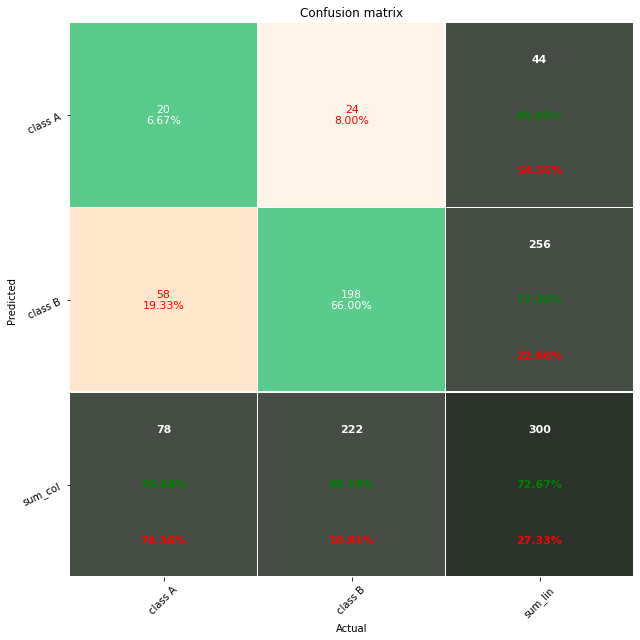

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


300


In [ ]:
# prepare cross validation
auprList = aucList = []
kfold = KFold(10, True, 1)
sensitivityList = specificityList = []
# enumerate splits
K_foldPredicts = []
for train, test in kfold.split(data['npi']):
    positiveData = data.iloc[train,2:][data['fraud_label']==1]
    negativeData = data.iloc[train,2:][data['fraud_label']==0]
    testLabel =  list(data.iloc[test,1])
    print(len(testLabel))
    testData =  data.iloc[test,2:]
#     print(negativeData.shape,positiveData.shape)
    predicList = []
    for i in range(len(testData.iloc[:,0])):
        predict = sim(testData.iloc[i,:],positiveData,negativeData,similarity='cosine')
#         print(predict,testLabel[i])
        predicList.append(predict)
    
    fpr, tpr, thr = roc_curve(testLabel, predicList)
    auc_val = auc(fpr, tpr)
    aucList.append(auc_val)
    K_foldPredicts.append(predicList)
    predicts1 = []

    for a in predicList:
        if a >=1:
            predicts1.append(1)
        else:
            predicts1.append(0)

    cm = confusion_matrix(list(predicts1), testLabel)
    print(cm)

    CR = classification_report(testLabel,list(predicts1))
    print(CR)
    plot_confusion_matrix_from_data(testLabel, list(predicts1))
    plt.show()
    sensitivityList.append(tpr[1])
    specificityList.append(1-fpr[1])
#     break
print(np.mean(auprList) , np.mean(aucList))
#     print('train: %s, test: %s' % (data.iloc[train,2:], data.iloc[test,2:]))

In [ ]:
confidence = 0.95
# data = [1, 2, 3, 4, 5]

naucList = len(aucList)
maucList = np.mean(aucList)
std_erraucList = sem(aucList)
haucList = std_erraucList * t.ppf((1 + confidence) / 2, naucList - 1)


nsensitivityList = len(sensitivityList)
msensitivityList = mean(sensitivityList)
std_errsensitivityList = sem(sensitivityList)
hsensitivityList = std_errsensitivityList * t.ppf((1 + confidence) / 2, nsensitivityList  - 1)

nspecificityList = len(specificityList)
mspecificityList = mean(specificityList)
std_errspecificityList = sem(specificityList)
hspecificityList = std_errspecificityList * t.ppf((1 + confidence) / 2, nspecificityList  - 1)



print("AUC:         "+ str(round(maucList,2)) + '  -+' + str(round(haucList,4)), '\nSensitivity: '+\
      str(round(msensitivityList,2)) + '  -+' + str(round(hsensitivityList,4)),\
      '\nSpecificity: ' + str(round(mspecificityList,2)) + '  -+' + str(round(hspecificityList,4)))